This notebook is used to evaluate the trained models on our own validation datasets. It builds upon scaaml.scaaml_intro.key_recovery_demo.ipynb. For this to work we had create our own versions of load_attack_shard to fit our data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
from keras import metrics
from tabulate import tabulate
import matplotlib.pyplot as plt
from multiprocessing import Pool
from random import randint
from typing import Any, Dict, List, Sequence
import time

import numpy.typing as npt
!pip install scaaml
from scaaml.aes import ap_preds_to_key_preds
from scaaml.plot import plot_trace, plot_confusion_matrix



In this cell we define methods from scaaml.scaaml.utils.py
We do this to avoid issues with dependencies in the scaaml library and our own environment.

In [3]:
from typing import Sequence, List
import numpy.typing as npt


def pretty_hex(e: int) -> str:
    """Representation of an integer as a zero-padded two-digit hex string."""
    return f"{e:02X}"


def hex_line(chars: Sequence[int], spacer: str = " ") -> str:
    """Render some chars as hex with a spacer between them"""
    h = []
    for e in chars:
        h.append(pretty_hex(e))
    return spacer.join(h)


def hex_display(lst: Sequence[int],
                prefix: str = "",
                color: str = "green") -> None:
    """Display a list of int as colored hex."""
    h = []
    for e in lst:
        h.append(pretty_hex(e))
    hex_representation = prefix + " ".join(h)
    # Assuming you print with some styled color effect
    print(f"{color}: {hex_representation}")  # Example use of the 'color' parameter

def from_categorical(predictions: Sequence[npt.ArrayLike]) -> List[np.intp]:
    "reverse of categorical"
    # note: doing it as a list is significantly faster than a single argmax
    return [np.argmax(p) for p in predictions]

def bytelist_to_hex(lst: Sequence[int], spacer: str = " ") -> str:
    h = []

    for e in lst:
        h.append(pretty_hex(e))
    return spacer.join(h)

This cell might throw an userwarning that can be safely ignored since we are not goint to train the model.

In [4]:
#importing the model we want to evaluate
import tensorflow as tf


#model = tf.keras.models.load_model("../models/stm32f415-tinyaes-cnn-v10-ap_sub_bytes_in-byte_0-len_5000.keras")
model = tf.keras.models.load_model("../models/stm32f0-tinyaes-cnn-v1-ap_sub_bytes_in-byte_0_len_5000.keras", compile=False)
#model = tf.keras.models.load_model("../models/stm32f0-tinyaes-cnn-v0-ap_sub_bytes_in-byte_0_len_5000.keras.keras")
#model = tf.keras.models.load_model("../models/stm32f0-tinyaes-cnn-v0-ap_sub_bytes_in-byte_0_len_5000.keras.keras")


These next cells can use a lot of memory.

In [5]:
ATTACK_POINT = 'sub_bytes_in'
ATTACK_BYTE = 0

In [27]:
import src.DAT255_SCA.utils.dataset_utils as utils
NUM_TRACES = 256  # maximum number of traces to use to recover a given key byte.
correct_prediction_rank = defaultdict(list)
y_pred = []
y_true = []
model_metrics = {"acc": metrics.Accuracy()}
file_path = "../datasets/attack/validation_cw1_rk_bt_3_0.hdf5"

#for løkken må endres fordi metoden returnerer en liste av alt
#heller iterere over i, siden første plassen i listen er all info for "shard 1"
x = []
y = []
keys = []
pts = []

x, y, keys, pts = utils.load_and_prepare_dataset_for_evaluation(file_path, ATTACK_BYTE, ATTACK_POINT, num_traces=NUM_TRACES)

for i in tqdm(range(len(x)), desc='Recovering bytes', unit='shards'):

    # prediction
    predictions = model.predict(x[i])

    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts[i], ATTACK_POINT)

    c_preds = from_categorical(predictions)
    c_y = from_categorical(y[i])


    # metric tracking
    for metric in model_metrics.values():
        metric.update_state(c_y, c_preds)
    # for the confusion matrix
    y_pred.extend(c_preds)
    y_true.extend(c_y)

    # accumulating probabilities and checking correct guess position.
    # if all goes well it will be at position 0 (highest probability)
    # see below on how to use for the real attack

    key = keys[i][0] # all the same in the same shard - not used in real attack
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22)
        guess_ranks = (np.argsort(vals, )[-256:][::-1])
        byte_rank = list(guess_ranks).index(key)
        correct_prediction_rank[trace_count].append(byte_rank)
    del predictions, key_preds, c_preds, c_y

Recovering bytes:   0%|          | 0/256 [00:00<?, ?shards/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 634ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 663ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 663ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 646ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 661ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 645ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 649ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 651ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 655ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 639ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 655ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 654ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 646ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 610ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 612ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 613ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 612ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 665ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 648ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 644ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 665ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 650ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 591ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 637ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 

The next for cells show relevant metrics for our model. They are explained in our report.

In [28]:
print("Accuracy: %.2f" % model_metrics['acc'].result())


Accuracy: 0.01


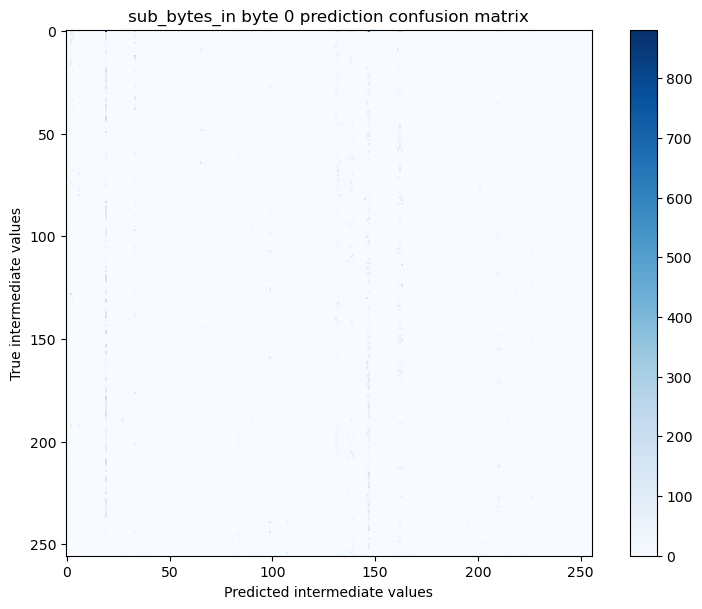

In [29]:
plot_confusion_matrix(y_true, y_pred, normalize=True, title="%s byte %s prediction confusion matrix" % (ATTACK_POINT, ATTACK_BYTE))


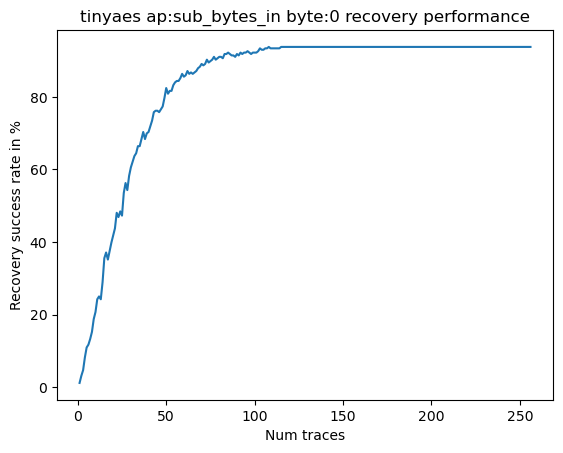

In [32]:
NUM_TRACES_TO_PLOT = 256
avg_preds = np.array([correct_prediction_rank[i].count(0) for i in range(NUM_TRACES_TO_PLOT)])
y = avg_preds / len(correct_prediction_rank[0]) * 100
x = [i + 1 for i in range(NUM_TRACES_TO_PLOT)]
plt.plot(x, y)
plt.xlabel("Num traces")
plt.ylabel("Recovery success rate in %")
plt.title("%s ap:%s byte:%s recovery performance" % ("tinyaes", ATTACK_POINT, ATTACK_BYTE))
plt.show()

In [33]:
min_traces = 0
max_traces = 0
cumulative_aa = 0
for idx, val in enumerate(y):
    cumulative_aa += val
    if not min_traces and val > 0:
        min_traces = idx + 1
    if not max_traces and val == 100.0:
        max_traces = idx + 1
        break

cumulative_aa = round( cumulative_aa / (idx + 1), 2) # divide by the number of steps

rows = [
    ["min traces", min_traces, round(y[min_traces -1 ], 1)],
    ["max traces", max_traces, round(y[max_traces - 1], 1)],
    ["cumulative score", cumulative_aa, '-']
]
print(tabulate(rows, headers=['metric', 'num traces', '% of keys']))

metric              num traces  % of keys
----------------  ------------  -----------
min traces                 1    1.2
max traces                 0    93.8
cumulative score          83.8  -


In [180]:
ATTACK_POINT = 'sub_bytes_in' # let's pick an attack point- Key is not a good target: it doesn't work for TinyAEs
TARGET_SHARD = 255 # a shard == a different key. Pick the one you would like
NUM_TRACES = 32 # how many traces to use - as seen in single byte
file_path = "../datasets/attack/validation_cw1_rk_bt_3_0.hdf5"


In [181]:
real_key = []
recovered_key = []

pb = tqdm(total=1, desc="Guessing key", unit='guesses')




for ATTACK_BYTE in range(1):
    x, y, keys, pts = utils.load_and_prepare_dataset_for_evaluation(file_path, ATTACK_BYTE, ATTACK_POINT, num_traces=NUM_TRACES)

    real_key.append(keys[TARGET_SHARD][ATTACK_BYTE])

    x = x[TARGET_SHARD]

    predictions = model.predict(x)

    key_preds = ap_preds_to_key_preds(predictions, pts[TARGET_SHARD], ATTACK_POINT)

    vals = np.zeros((256,))
    for trace_count, kp in enumerate(key_preds):
        vals += np.log10(kp + 1e-22)

    guess_ranks = np.argsort(vals)[::-1]
    recovered_key.append(guess_ranks[0])


    pb.set_postfix({
        'Recovered key': bytelist_to_hex(recovered_key),
        'Real key': bytelist_to_hex(real_key)
    })
    pb.update()

pb.close()


Guessing key:   0%|          | 0/1 [00:00<?, ?guesses/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
